In [1]:
import tensorflow as tf
import os
import pandas as pd
import pickle
import numpy as np
import cv2
%matplotlib inline
import matplotlib.pyplot as plt

import matplotlib.image as mpimg

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
%cd ~
%cd /content/gdrive/My Drive/Neural Network/P2/

In [ ]:
%ls Proj2_data/data2

In [ ]:
# os.mkdir('d2')

In [ ]:
%ls

In [ ]:
# import zipfile
# with zipfile.ZipFile('/content/gdrive/My Drive/Neural Network/P2/Proj2_data/data2/pics.zip', 'r') as zip_ref:
#     zip_ref.extractall('/content/gdrive/My Drive/Neural Network/P2/d2')

In [2]:
features = pd.read_csv('desc.csv')
features.head(10)

,image_id,street,city,n_city,bed,bath,sqft,price
0,0,1317 Van Buren Avenue,"Salton City, CA",317,3,2.0,1560,201900
1,1,124 C Street W,"Brawley, CA",48,3,2.0,713,228500
2,2,2304 Clark Road,"Imperial, CA",152,3,1.0,800,273950
3,3,755 Brawley Avenue,"Brawley, CA",48,3,1.0,1082,350000
4,4,2207 R Carrillo Court,"Calexico, CA",55,4,3.0,2547,385100
5,5,755 Brawley Avenue,"Brawley, CA",48,3,1.0,1082,350000
6,6,1100 CAMILIA Street,"Calexico, CA",55,4,3.0,2769,415000
7,7,803 Chaparral Court,"Brawley, CA",48,5,2.1,2600,545000
8,8,803 Chaparral Court,"Brawley, CA",48,5,2.1,2600,545000
9,9,2306 Lark Court,"Salton City, CA",317,4,5.1,3932,690000


In [3]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15474 entries, 0 to 15473
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   image_id  15474 non-null  int64  
 1   street    15474 non-null  object 
 2   city      15474 non-null  object 
 3   n_city    15474 non-null  int64  
 4   bed       15474 non-null  int64  
 5   bath      15474 non-null  float64
 6   sqft      15474 non-null  int64  
 7   price     15474 non-null  int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 967.2+ KB


In [4]:
features.describe()

,image_id,n_city,bed,bath,sqft,price
count,15474.000000,15474.000000,15474.000000,15474.000000,15474.000000,1.547400e+04
mean,7736.500000,216.597518,3.506398,2.453251,2173.913209,7.031209e+05
std,4467.103368,112.372985,1.034838,0.958742,1025.339617,3.769762e+05
min,0.000000,0.000000,1.000000,0.000000,280.000000,1.950000e+05
25%,3868.250000,119.000000,3.000000,2.000000,1426.000000,4.450000e+05
50%,7736.500000,222.500000,3.000000,2.100000,1951.000000,6.390000e+05
75%,11604.750000,315.000000,4.000000,3.000000,2737.750000,8.349750e+05
max,15473.000000,414.000000,12.000000,36.000000,17667.000000,2.000000e+06


# Preprocessing

In [5]:
# check if there is any duplicated data

In [5]:
duplicate = features.duplicated()
features[duplicate]

,image_id,street,city,n_city,bed,bath,sqft,price


In [7]:
# check for outliers

<function matplotlib.pyplot.show(*args, **kw)>

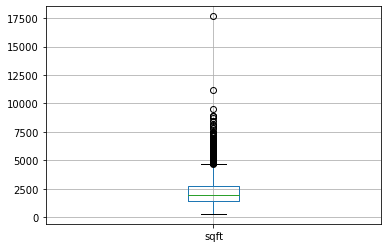

In [6]:
features.boxplot(column=['sqft'])
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

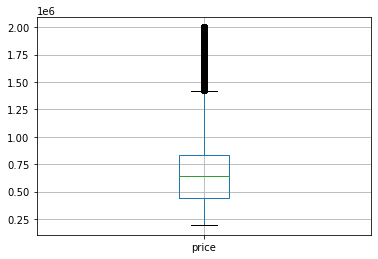

In [7]:
features.boxplot(column=['price'])
plt.show

In [8]:
# now that there are outliers, we're going to normalize them with OQR method

In [9]:
def remove_outlier(col):
    sorted(col)
    Q1, Q3 = col.quantile([0.25, 0.75])
    IQR = Q3-Q1
    lower_range = Q1-(1.5*IQR)
    upper_range = Q3+(1.5*IQR)
    return lower_range, upper_range

In [10]:
lowPrice, highPrice = remove_outlier(features['price'])
lowSqft, highSqft = remove_outlier(features['sqft'])
features['price'] = np.where(features['price']>highPrice, highPrice, features['price'])
features['price'] = np.where(features['price']<lowPrice, lowPrice, features['price'])
features['sqft'] = np.where(features['sqft']>highSqft, highSqft, features['sqft'])
features['sqft'] = np.where(features['sqft']<lowSqft, lowSqft, features['sqft'])

In [11]:
# as plots show, no more outliers left.

<function matplotlib.pyplot.show(*args, **kw)>

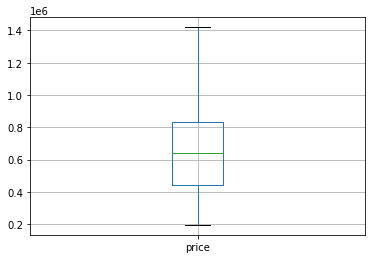

In [12]:
features.boxplot(column=['price'])
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

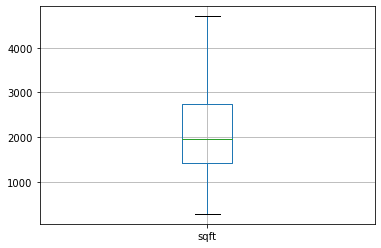

In [13]:
features.boxplot(column=['sqft'])
plt.show

In [14]:
# counting number of unique values in columns for choosing the correct encoding scheme for each


In [15]:
features.shape

(15474, 8)

In [124]:
# drop some unimportant columns and divide bath column to full bath and half bath

In [16]:
features['full_bath'] = features.bath.map(lambda x:int(x))
features['half_bath'] = (features.bath-features.full_bath).map(lambda x:int(0.01+(10*x))) # +0.01 is for handling rounding error
features = features.drop(['bath', 'street', 'city', 'image_id'], axis=1)

In [17]:
# print('#street: ', features.street.nunique())
# print('#city: ', features.n_city.nunique())
print('#half_bath: ', features.half_bath.nunique())
print('#full_bath: ', features.full_bath.nunique())
print('#bedroom: ', features.bed.nunique())

#half_bath:  5
#full_bath:  12
#bedroom:  12


In [125]:
# normalize numerical data 

In [18]:
from sklearn.preprocessing import MinMaxScaler
features[['price', 'sqft']] = MinMaxScaler().fit_transform(features[['price', 'sqft']])

In [19]:
features.head(10)

,n_city,bed,sqft,price,full_bath,half_bath
0,317,3,0.289241,0.005633,2,0
1,48,3,0.097845,0.027348,2,0
2,152,3,0.117504,0.064452,1,0
3,48,3,0.181228,0.126537,1,0
4,55,4,0.512273,0.155192,3,0
5,48,3,0.181228,0.126537,1,0
6,55,4,0.562438,0.179601,3,0
7,48,5,0.524249,0.285729,2,1
8,48,5,0.524249,0.285729,2,1
9,317,4,0.825241,0.404102,5,1


In [126]:
# for adding 'img_' prefix to images so ImageDataGenerator doesnt raise float32 error for filename

In [ ]:
# import os
# path = 'd2/pics'
# files = os.listdir(path)
# pre = 'img_'

# for file in files:
#     os.rename(os.path.join(path, file), os.path.join(path, pre+file))

In [127]:
# simply loading data for ploting some samples

In [22]:
# import os
# import numpy as np
# import cv2
# from PIL import Image
# image_list = []

# for root, dirs, files in os.walk("d2/pics"):
#     for filename in files:
#         im=np.array(cv2.resize(Image.open('d2/pics/'+filename), (128,128)))
#         image_list.append(im)

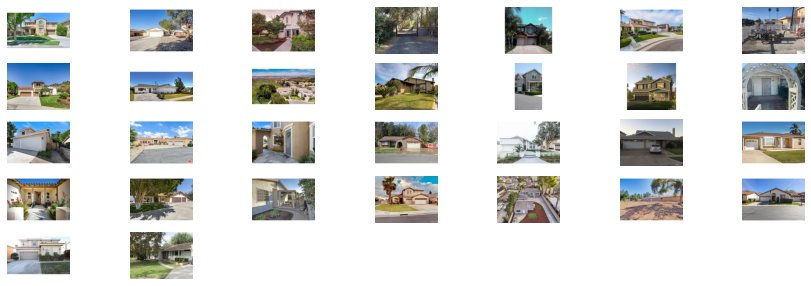

In [67]:
# # displaying some images
# import matplotlib.pyplot as plt
# def display_images(images, limit):
#     from random import choices

#     plt.figure(figsize=(15, 5))
#     i = 1
#     rand_list=choices(images, k=limit)
#     for j in rand_list:
#         image = j
#         plt.subplot(5, 7, i)  # 3 rows, 8 per row
#         plt.axis('off')
#         i += 1
#         plt.imshow(image)
#     plt.show()

# display_images(image_list, 30)

import the files with TF



In [ ]:
# in order to define a multi input model with two differnet networks, we need a new generator for feeding it to the network
# this class inherits from keras sequence class and acts as a generator knowable for fit function

In [66]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import Sequence

class image_dir_df_generator(Sequence):

    def __init__(self, img_path, df, y, img_height, img_width, batch_size):
        import numpy as np
        import pandas as pd
        import glob
        
        # assert features.shape[:5000] == len(glob.glob(img_path+'\valid\*'))
        # assert features.shape[5000:] == len(glob.glob(img_path+'\train\*'))

        self.datagen = ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.1,
            height_shift_range=0.1,
            rescale=1./255,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest'
            )

        self.image_gen = self.datagen.flow_from_directory(
            batch_size=batch_size,
            directory=img_path,
            shuffle=False,
            class_mode=None,
            target_size=(img_height, img_width),
        )

        self.dataframe = df
        self.y = y
        self.batch_size = batch_size

    def __len__(self):
        return int(np.floor(self.image_gen.__len__()/self.batch_size))

    def __getitem__(self, index):
        image = next(self.image_gen)
        attrX = self.dataframe.iloc[index*self.batch_size:(index+1)*self.batch_size].values
        attry = self.y.iloc[index*self.batch_size:(index+1)*self.batch_size]
        
        batchX = [attrX, image]
        
        return batchX, attry

    def __iter__(self):
        """Create a generator that iterate over the Sequence."""
        for x, y in (self.__getitem__(i) for i in range(self.__len__())):
            yield x, y


In [128]:
# other way of creating a generator is through defining a function that yields batches of data
# consisted of dataframe and image batches as features and price values as target

In [134]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_dir = os.getcwd()+'\d2'

img_height, img_width = 128, 128
batch_size = 32
df = features.drop(['price'], axis=1)
y = features.price


datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        rescale=1./255,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

image_gen = datagen.flow_from_directory(
batch_size=batch_size,
directory=image_dir,
class_mode=None,
shuffle=False,
target_size=(img_height, img_width),
)

def image_dir_df_gen(df, y, batch_size):
    index = 0
    while True:
        if index > int(np.floor(image_gen.__len__()/batch_size)):
            image_gen.reset()
            index = 0
        dataframe = df.iloc[index*batch_size:(index+1)*batch_size].values
        target = y.iloc[index*batch_size:(index+1)*batch_size].values
        img = next(image_gen)
        index+=1
        yield [dataframe ,img], target


Found 15474 images belonging to 1 classes.


In [120]:
image_dir = os.getcwd()+'\d2'

img_height, img_width = 128, 128
batch_size = 32

valid_generator = image_dir_df_generator(image_dir, features.drop(['price'], axis=1), features.price, img_height, img_width, batch_size)


Found 15474 images belonging to 1 classes.


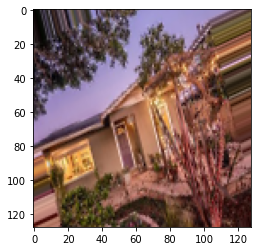

In [125]:
plt.imshow(next(image_gen)[0])

In [ ]:
# defining a mlp and a cnn model for modeling the underlying strucutre in csv and image data

In [129]:
from tensorflow.keras import layers, Sequential
dim = features.shape[1]-1# number of columns
mlp = Sequential([
    layers.Dense(16, input_dim=dim, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(4, activation='relu'),
])
cnn = Sequential([
    layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(img_height, img_width, 3)),
    layers.AveragePooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.BatchNormalization(-1),
    layers.AveragePooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.BatchNormalization(-1),
    layers.AveragePooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.BatchNormalization(-1),
    layers.AveragePooling2D(),
    layers.Flatten(),
    layers.Dense(16, activation='relu'),
    layers.BatchNormalization(-1),
    layers.Dropout(0.2),
    layers.Dense(4, activation='relu'),

])

In [ ]:
# concatenating mlp and cnn outputs and merging them into one united model

In [130]:
from tensorflow.keras.layers import concatenate, Dense
from tensorflow.keras import Model

combinedInput = concatenate([mlp.output, cnn.output])

x = Dense(4, activation="relu")(combinedInput)
x = Dense(1, activation="linear")(x)

model = Model(inputs=[mlp.input, cnn.input], outputs=x)

In [132]:
from tensorflow.keras.optimizers import Adam
opt = Adam(lr=1e-3, decay=1e-3 / 200)
model.compile(
    loss="mean_absolute_percentage_error", 
    optimizer=opt
    )

In [135]:
history = model.fit(
    image_dir_df_gen(df, y, batch_size),
    steps_per_epoch=int(len(features.index)/batch_size),
    epochs=10
)

Epoch 1/10
483/483 [==============================] - 89s 185ms/step - loss: 3308666.2500
Epoch 2/10
483/483 [==============================] - 105s 218ms/step - loss: 329547.3438
Epoch 3/10
483/483 [==============================] - 110s 229ms/step - loss: 364537.7188
Epoch 4/10
483/483 [==============================] - 115s 238ms/step - loss: 169180.8594
Epoch 5/10
483/483 [==============================] - 113s 233ms/step - loss: 114673.3516
Epoch 6/10
483/483 [==============================] - 112s 231ms/step - loss: 95514.4453
Epoch 7/10
483/483 [==============================] - 113s 233ms/step - loss: 204269.0156
Epoch 8/10
483/483 [==============================] - 112s 232ms/step - loss: 88128.8281
Epoch 9/10
483/483 [==============================] - 114s 236ms/step - loss: 59955.5430
Epoch 10/10
483/483 [==============================] - 112s 231ms/step - loss: 42947.6758


In [199]:
# model.save('p22_regression.h5')
# model.save_weights('p22_regression_wights.h5')

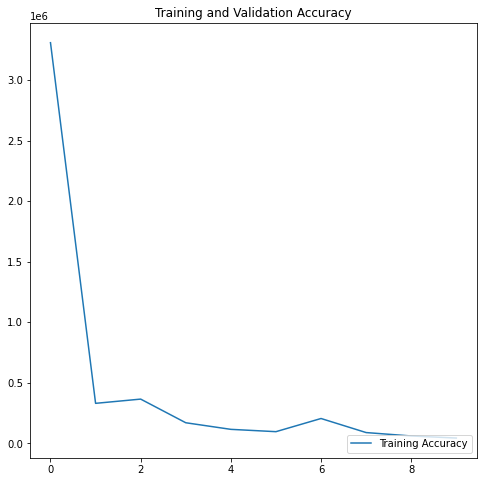

In [136]:
loss = history.history['loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.plot(epochs_range, loss, label='Training Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.show()

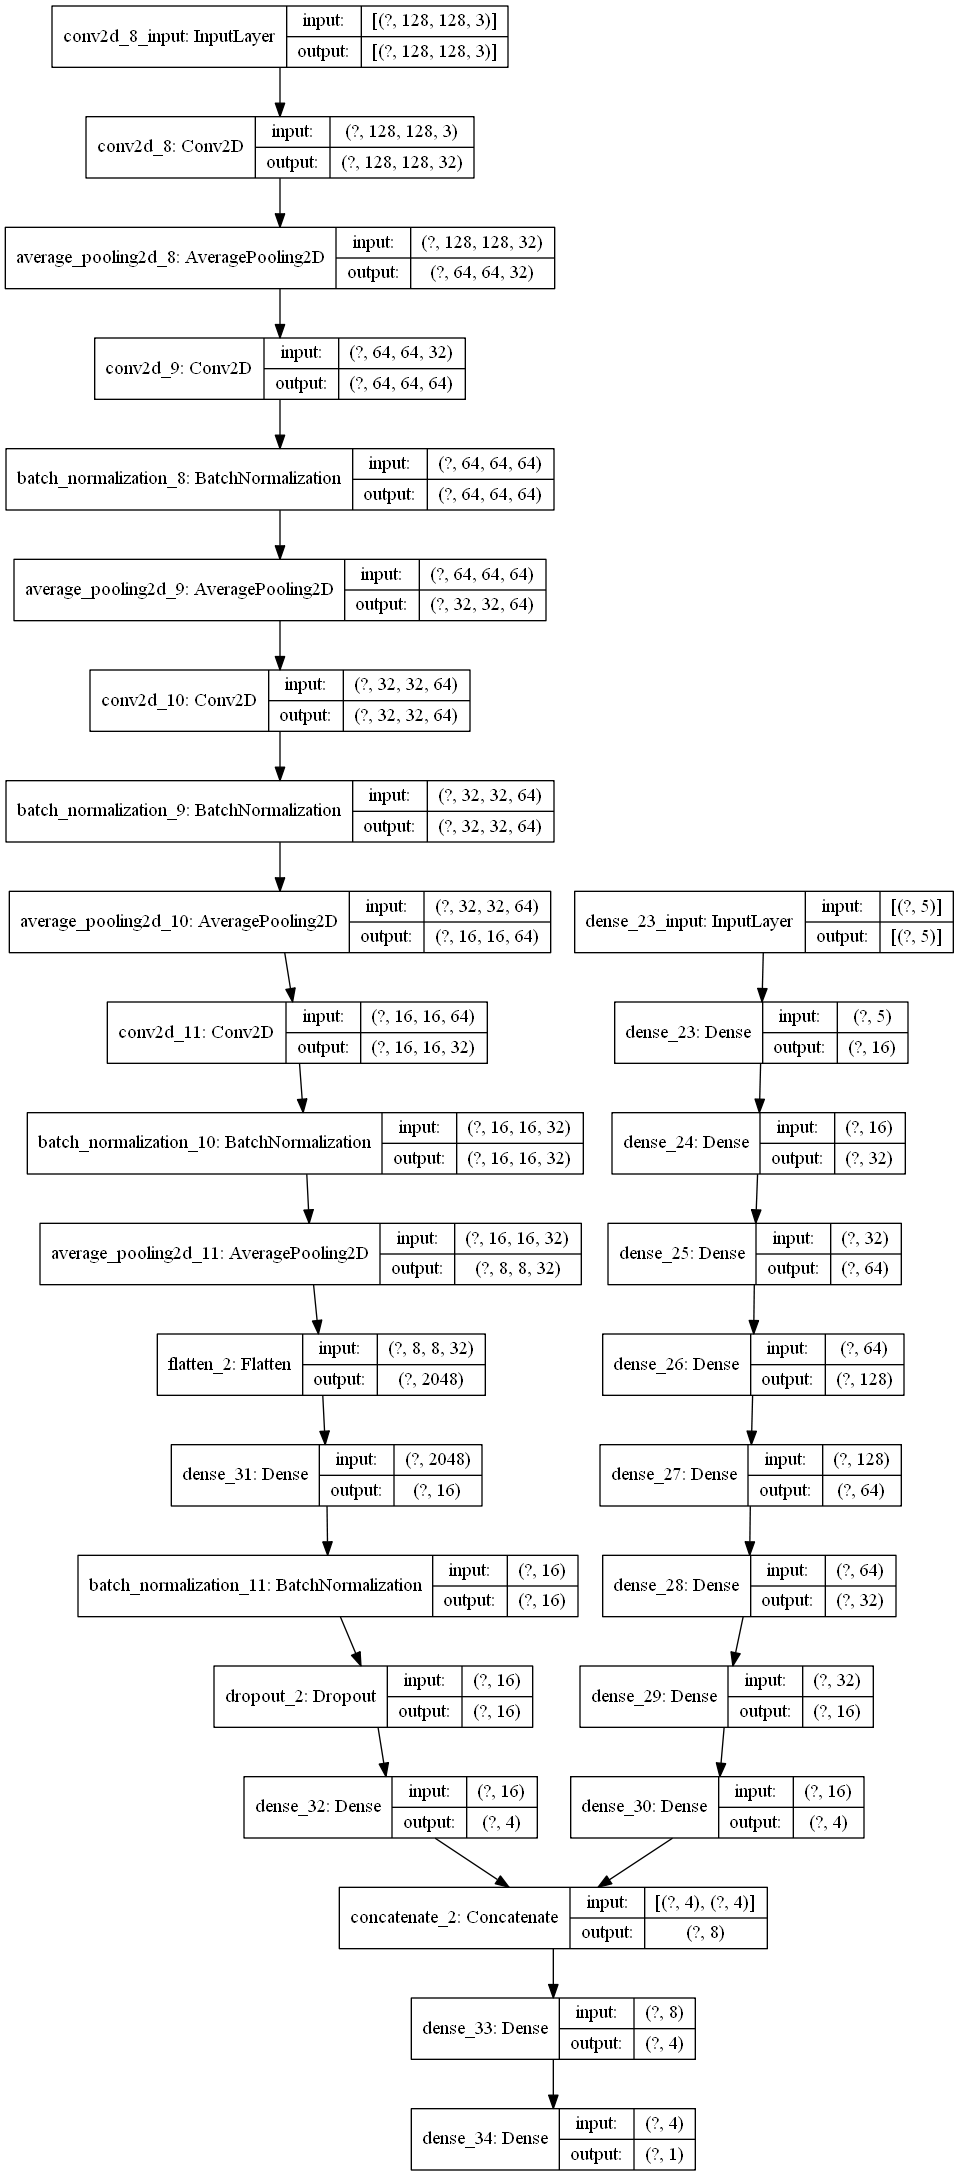

In [137]:
tf.keras.utils.plot_model(model, "mlp_cnn.png", show_shapes=True)

In [200]:
# now we test that if house pictures did any good to the model loss

In [189]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
mlp_reg_data = pd.read_csv('desc.csv')
mlp_reg_data.drop(['image_id', 'street', 'city', 'n_city'], inplace=True, axis=1)
mlp_reg_data[['sqft', 'price']] = scaler.fit_transform(mlp_reg_data[['sqft', 'price']])

In [193]:
mlp_reg_data.head()

,bed,bath,sqft,price
0,3,2.0,0.073618,0.003823
1,3,2.0,0.024904,0.018560
2,3,1.0,0.029907,0.043740
3,3,1.0,0.046126,0.085873
4,4,3.0,0.130385,0.105319


In [194]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

dim = mlp_reg_data.shape[-1]-1

mlp = Sequential([
    layers.Dense(16, input_dim=dim, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='relu'),
])

In [195]:
from tensorflow.keras.layers import Dense
# mlp.add(Dense(1, activation='relu'))
mlp_reg = mlp
mlp_reg.compile(
    loss='mse',
    optimizer='adam'
    # metrics=['mse']
)

In [196]:
x_train = mlp_reg_data.drop(['price'], axis=1).iloc[5000:]
y_train = mlp_reg_data.price.iloc[5000:]
x_test = mlp_reg_data.drop(['price'], axis=1).iloc[:5000]
y_test = mlp_reg_data.price.iloc[:5000]
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

mlp_history = mlp_reg.fit(
    x=x_train,
    y=y_train,
    validation_split=0.2,
    callbacks=callback,
    epochs=50
)

Epoch 1/50
262/262 [==============================] - 1s 3ms/step - loss: 0.1080 - val_loss: 0.1707
Epoch 2/50
262/262 [==============================] - 1s 3ms/step - loss: 0.1080 - val_loss: 0.1707
Epoch 3/50
262/262 [==============================] - 1s 3ms/step - loss: 0.1080 - val_loss: 0.1707
Epoch 4/50
262/262 [==============================] - 1s 3ms/step - loss: 0.1080 - val_loss: 0.1707
Epoch 5/50
262/262 [==============================] - 1s 3ms/step - loss: 0.1080 - val_loss: 0.1707


In [197]:
pred = mlp_reg.predict(x_test).reshape(5000)
res = pd.DataFrame()
res['pred'] = pred
res['y'] = y_test
res['diff'] = (res.pred-res.y).map(lambda x:abs(x))

In [198]:
res

,pred,y,diff
0,0.0,0.003823,0.003823
1,0.0,0.018560,0.018560
2,0.0,0.043740,0.043740
3,0.0,0.085873,0.085873
4,0.0,0.105319,0.105319
...,...,...,...
4995,0.0,0.528532,0.528532
4996,0.0,0.534626,0.534626
4997,0.0,0.598338,0.598338
4998,0.0,0.720222,0.720222


In [201]:
# as we can see mse has improved significantly and adding images to the model was a total drawback